# Modeling and Simulation in Python

Starter code for the orbit example

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [14]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import numpy as np

### Earth falling into the sun

Here's a question from the web site [Ask an Astronomer](http://curious.astro.cornell.edu/about-us/39-our-solar-system/the-earth/other-catastrophes/57-how-long-would-it-take-the-earth-to-fall-into-the-sun-intermediate):

"If the Earth suddenly stopped orbiting the Sun, I know eventually it would be pulled in by the Sun's gravity and hit it. How long would it take the Earth to hit the Sun? I imagine it would go slowly at first and then pick up speed."

Here's a solution.

In [15]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter

<Unit('meter')>

In [46]:
# And an inition condition (with everything in SI units)

r_0 = 147e9 * m

init = State(x = r_0,
             y = 0 * m,
             vx = 0 * m / s,
             vy = -30330 * m / s)

,values
x,147000000000.0 meter
y,0 meter
vx,0.0 meter / second
vy,-30330.0 meter / second


In [47]:
# Making a system object

r_earth = 6.371e6 * m
r_sun = 695.508e6 * m

system = System(init=init,
                G=6.674e-11 * N / kg**2 * m**2,
                m1=1.989e30 * kg,
                r_final=r_sun + r_earth,
                m2=5.972e24 * kg,
                t_0=0 * s,
                t_end= 3.154e7 * s) #a year in seconds

,values
init,x 147000000000.0 meter y ...
G,6.674e-11 meter ** 2 * newton / kilogram ** 2
m1,1.989e+30 kilogram
r_final,701879000.0 meter
m2,5.972e+24 kilogram
t_0,0 second
t_end,31540000.0 second


In [48]:
# Here's a function that computes the force of gravity

def universal_gravitation(state, system):
    """Computes gravitational force.
    
    state: State object with distance r
    system: System object with m1, m2, and G
    """ 
    x, y, vx, vy = state
    unpack(system)
    
    pos = Vector(x,y)
    r = pos.mag
    force = G * m1 * m2 / r**2
    return Vector(force*np.cos(pos.angle), force*np.sin(pos.angle))

In [49]:
universal_gravitation(init, system)

<Quantity([3.6686486e+22 0.0000000e+00], 'newton')>

In [50]:
# The slope function

def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x, y, vx, vy = state
    unpack(system)    
    
    force = -universal_gravitation(state,system) 
    dxdt = vx
    dydt = vy
    ax = force.x/ m2
    ay = force.y/ m2
    return dxdt, dydt, ax, ay

In [51]:
# Always test the slope function!
dxdt, dydt, ax, ay = slope_func(init, 0, system)
print(dxdt)
print(dydt)
print(ax)
print(ay)
slope_func(init, 0, system)

0.0 meter / second
-30330.0 meter / second
-0.006143082049146188 newton / kilogram
-0.0 newton / kilogram


(<Quantity(0.0, 'meter / second')>,
 <Quantity(-30330.0, 'meter / second')>,
 <Quantity(-0.006143082049146188, 'newton / kilogram')>,
 <Quantity(-0.0, 'newton / kilogram')>)

In [52]:
# Here's an event function that stops the simulation
# before the collision

def event_func(state, t, system):
    unpack(system)
    return t - t_end

In [53]:
# Always test the event function!

event_func(init, 0, system)

<Quantity(-31540000.0, 'second')>

In [54]:
# Finally we can run the simulation

results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[31540000.0]]
nfev,152
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [55]:
# Here's how long it takes...

t_final = get_last_label(results) * s

<Quantity(31540000.0, 'second')>

In [56]:
# ... expressed in units we understand

t_final.to(UNITS.day)

<Quantity(365.04629629629625, 'day')>

In [59]:
# Before plotting, we run the simulation again with `t_eval`

ts = linspace(t_0, t_final, 201)
results, details = run_ode_solver(system, slope_func, events=event_func, method='RK23', t_eval=ts)

In [60]:
# Scaling the time steps to days

results.index /= 60 * 60 * 24

In [61]:
# Scaling the distance to million km

x = results.x / 1e9;
y = results.y / 1e9;

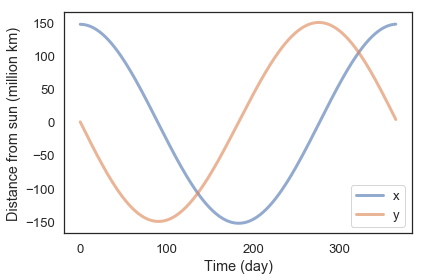

In [62]:
# And plotting

plot(x, label='x')
plot(y, label='y')

decorate(xlabel='Time (day)',
         ylabel='Distance from sun (million km)')

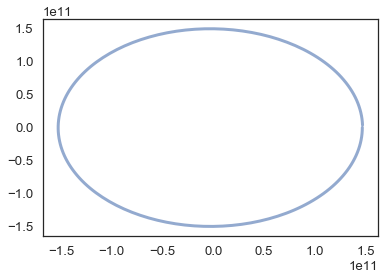

In [63]:
plot(results.x, results.y, label='s')